In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import numpy as np
from matplotlib import pyplot as plt

from keras.layers import Dense, Input
from keras.models import Model

import omnifold as of
import os
import tensorflow as tf
import tensorflow_probability as tfp

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
#tf.config.experimental.set_virtual_device_configuration(
#    gpus[1],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[]


In [4]:
# Define number of samples
N = 10**7

# Define a 2D multivariate Gaussian distribution to stand in for Generation
theta0_G_dist = tfp.distributions.MultivariateNormalTriL(loc=[0.2, -0.3], scale_tril=[[0.2, 2.0], [0, 0.4]])
theta0_G = theta0_G_dist.sample(N)

# Define another 2D multivariate Gaussian distribution to stand in for the detector response
# Note we will smear the second dimensions much more than the first
det_smear_dist = tfp.distributions.MultivariateNormalDiag(loc=[0, 0], scale_diag=[0.1, 0.5])

# Smear generation sample with detector response
theta0_S = theta0_G + det_smear_dist.sample(N)

# Finally define the 2D multivariate Gaussian distribution to stand in for the data
# Note this is just a unit normal with no covariance. Let's see if of can remove the correlation.
theta_unknown_G_dist = tfp.distributions.MultivariateNormalDiag(loc=[0.0, 0.0], scale_diag=[0.4, 0.3]) 
theta_unknown_G = theta_unknown_G_dist.sample(N)
theta_unknown_S = theta_unknown_G + det_smear_dist.sample(N)

# Zip generation and simulation, truth and data
theta0 = np.stack([theta0_G, theta0_S], axis=-1)
theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=-1)

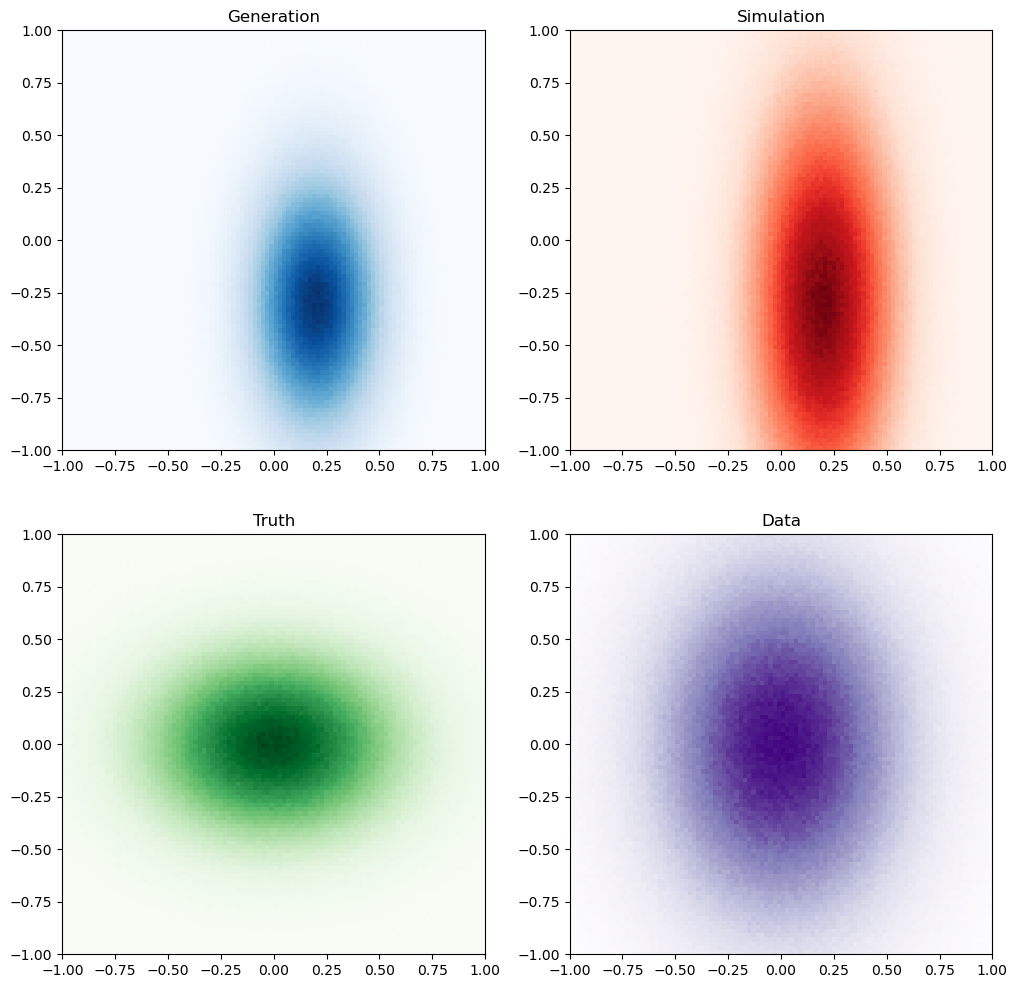

In [5]:
# Make a 2D histogram of the data
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.title('Generation')
plt.hist2d(theta0_G[:,0], theta0_G[:,1], bins=100, range=[[-1,1],[-1,1]], cmap='Blues', label='Generation')
plt.subplot(2,2,2)
plt.title('Simulation')
plt.hist2d(theta0_S[:,0], theta0_S[:,1], bins=100, range=[[-1,1],[-1,1]], cmap='Reds', label='Simulation')
plt.subplot(2,2,3)
plt.title('Truth')
plt.hist2d(theta_unknown_G[:,0], theta_unknown_G[:,1], bins=100, range=[[-1,1],[-1,1]], cmap='Greens', label='Truth')
plt.subplot(2,2,4)
plt.title('Data')
plt.hist2d(theta_unknown_S[:,0], theta_unknown_S[:,1], bins=100, range=[[-1,1],[-1,1]], cmap='Purples', label='Data')
plt.show()

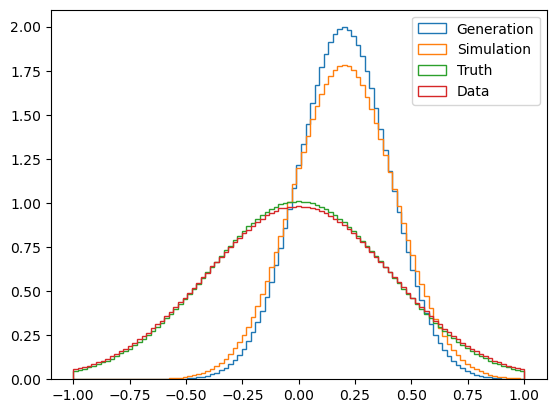

In [8]:
# Make histograms of the first dimension
plt.clf()
bins = np.linspace(-1,1,100)
plt.hist(theta0_G[:,0].numpy(), bins=bins, range=[-1,1], histtype='step', label='Generation', density=True)
plt.hist(theta0_S[:,0].numpy(), bins=bins, range=[-1,1], histtype='step', label='Simulation', density=True)
plt.hist(theta_unknown_G[:,0].numpy(), bins=bins, range=[-1,1], histtype='step', label='Truth', density=True)
plt.hist(theta_unknown_S[:,0].numpy(), bins=bins, range=[-1,1], histtype='step', label='Data', density=True)
plt.legend()
plt.show()

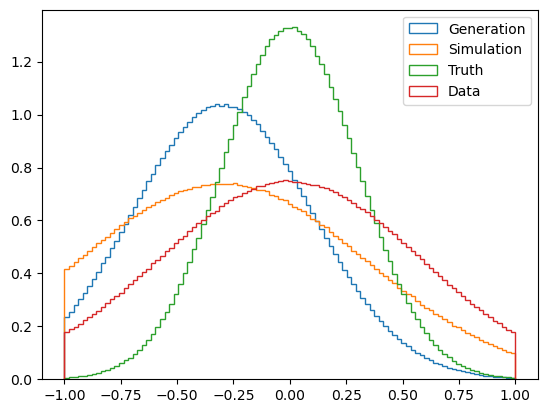

In [9]:
# Make histograms of the second dimension
plt.clf()
bins = np.linspace(-1,1,100)
plt.hist(theta0_G[:,1].numpy(), bins=bins, range=[-1,1], histtype='step', label='Generation', density=True)
plt.hist(theta0_S[:,1].numpy(), bins=bins, range=[-1,1], histtype='step', label='Simulation', density=True)
plt.hist(theta_unknown_G[:,1].numpy(), bins=bins, range=[-1,1], histtype='step', label='Truth', density=True)
plt.hist(theta_unknown_S[:,1].numpy(), bins=bins, range=[-1,1], histtype='step', label='Data', density=True)
plt.legend()
plt.show()

In [10]:
inputs = Input((2, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

In [17]:
myweights = of.omnifold(theta0, theta_unknown_S, 5, model, verbose=1)


ITERATION: 1

STEP 1



Epoch 1/3
1500/1500 - 7s - loss: 0.5654 - accuracy: 0.5438 - val_loss: 0.5590 - val_accuracy: 0.5426 - 7s/epoch - 5ms/step
Epoch 2/3
1500/1500 - 6s - loss: 0.5590 - accuracy: 0.5422 - val_loss: 0.5590 - val_accuracy: 0.5442 - 6s/epoch - 4ms/step
Epoch 3/3
1500/1500 - 7s - loss: 0.5589 - accuracy: 0.5420 - val_loss: 0.5590 - val_accuracy: 0.5380 - 7s/epoch - 4ms/step

STEP 2



Epoch 1/3
7500/7500 - 14s - loss: 0.5848 - accuracy: 0.2964 - val_loss: 0.5850 - val_accuracy: 0.2940 - 14s/epoch - 2ms/step
Epoch 2/3
7500/7500 - 13s - loss: 0.5848 - accuracy: 0.2965 - val_loss: 0.5849 - val_accuracy: 0.2953 - 13s/epoch - 2ms/step
Epoch 3/3
7500/7500 - 13s - loss: 0.5848 - accuracy: 0.2965 - val_loss: 0.5849 - val_accuracy: 0.2941 - 13s/epoch - 2ms/step

ITERATION: 2

STEP 1



Epoch 1/3
1500/1500 - 7s - loss: 0.6547 - accuracy: 0.4791 - val_loss: 0.6441 - val_accuracy: 0.4888 - 7s/epoch - 5ms/step
Epoch 2/3
1500/1500 - 7s - loss: 0.6453 - accuracy: 0.4880 - val_loss: 0.6439 - val_accuracy: 0.4913 - 7s/epoch - 5ms/step
Epoch 3/3
1500/1500 - 7s - loss: 0.6452 - accuracy: 0.4881 - val_loss: 0.6438 - val_accuracy: 0.4861 - 7s/epoch - 5ms/step

STEP 2



Epoch 1/3
7500/7500 - 13s - loss: 0.5473 - accuracy: 0.2954 - val_loss: 0.5459 - val_accuracy: 0.2950 - 13s/epoch - 2ms/step
Epoch 2/3
7500/7500 - 12s - loss: 0.5458 - accuracy: 0.2941 - val_loss: 0.5459 - val_accuracy: 0.2942 - 12s/epoch - 2ms/step
Epoch 3/3
7500/7500 - 12s - loss: 0.5458 - accuracy: 0.2942 - val_loss: 0.5459 - val_accuracy: 0.2948 - 12s/epoch - 2ms/step

ITERATION: 3

STEP 1



Epoch 1/3
1500/1500 - 7s - loss: 0.6891 - accuracy: 0.4609 - val_loss: 0.6789 - val_accuracy: 0.4928 - 7s/epoch - 5ms/step
Epoch 2/3
1500/1500 - 7s - loss: 0.6695 - accuracy: 0.4776 - val_loss: 0.6790 - val_accuracy: 0.4822 - 7s/epoch - 5ms/step
Epoch 3/3
1500/1500 - 7s - loss: 0.6695 - accuracy: 0.4734 - val_loss: 0.6779 - val_accuracy: 0.4774 - 7s/epoch - 5ms/step

STEP 2



Epoch 1/3
7500/7500 - 13s - loss: 0.5392 - accuracy: 0.3005 - val_loss: 0.5368 - val_accuracy: 0.2966 - 13s/epoch - 2ms/step
Epoch 2/3
7500/7500 - 13s - loss: 0.5369 - accuracy: 0.2994 - val_loss: 0.5368 - val_accuracy: 0.2995 - 13s/epoch - 2ms/step
Epoch 3/3
7500/7500 - 13s - loss: 0.5369 - accuracy: 0.2994 - val_loss: 0.5367 - val_accuracy: 0.3003 - 13s/epoch - 2ms/step

ITERATION: 4

STEP 1



Epoch 1/3
1500/1500 - 7s - loss: 0.7203 - accuracy: 0.4047 - val_loss: 0.6915 - val_accuracy: 0.4648 - 7s/epoch - 5ms/step
Epoch 2/3
1500/1500 - 8s - loss: 0.6909 - accuracy: 0.4217 - val_loss: 0.6912 - val_accuracy: 0.3665 - 8s/epoch - 5ms/step
Epoch 3/3
1500/1500 - 7s - loss: 0.6905 - accuracy: 0.4246 - val_loss: 0.6909 - val_accuracy: 0.3852 - 7s/epoch - 4ms/step

STEP 2



Epoch 1/3
7500/7500 - 14s - loss: 0.5228 - accuracy: 0.2999 - val_loss: 0.5201 - val_accuracy: 0.2973 - 14s/epoch - 2ms/step
Epoch 2/3
7500/7500 - 13s - loss: 0.5202 - accuracy: 0.2994 - val_loss: 0.5202 - val_accuracy: 0.3000 - 13s/epoch - 2ms/step
Epoch 3/3
7500/7500 - 13s - loss: 0.5202 - accuracy: 0.2994 - val_loss: 0.5201 - val_accuracy: 0.2987 - 13s/epoch - 2ms/step

ITERATION: 5

STEP 1



Epoch 1/3
1500/1500 - 7s - loss: 0.7105 - accuracy: 0.4620 - val_loss: 0.6696 - val_accuracy: 0.4600 - 7s/epoch - 5ms/step
Epoch 2/3
1500/1500 - 7s - loss: 0.6718 - accuracy: 0.4804 - val_loss: 0.6694 - val_accuracy: 0.4863 - 7s/epoch - 5ms/step
Epoch 3/3
1500/1500 - 7s - loss: 0.6717 - accuracy: 0.4738 - val_loss: 0.6694 - val_accuracy: 0.4748 - 7s/epoch - 5ms/step

STEP 2



Epoch 1/3
7500/7500 - 13s - loss: 0.5168 - accuracy: 0.3010 - val_loss: 0.5136 - val_accuracy: 0.3009 - 13s/epoch - 2ms/step
Epoch 2/3
7500/7500 - 12s - loss: 0.5136 - accuracy: 0.3006 - val_loss: 0.5136 - val_accuracy: 0.3002 - 12s/epoch - 2ms/step
Epoch 3/3
7500/7500 - 12s - loss: 0.5136 - accuracy: 0.3006 - val_loss: 0.5136 - val_accuracy: 0.2994 - 12s/epoch - 2ms/step


In [18]:
print(myweights[0,1,:].max())
print(myweights[1,1,:].max())
print(myweights[2,1,:].max())
print(myweights[3,1,:].max())
print(myweights[4,1,:].max())

2016.2197265625
7566.53076171875
14780.6884765625
18019.640625
17790.322265625


In [ ]:
clipped_weights = np.clip(myweights, 0, 50)

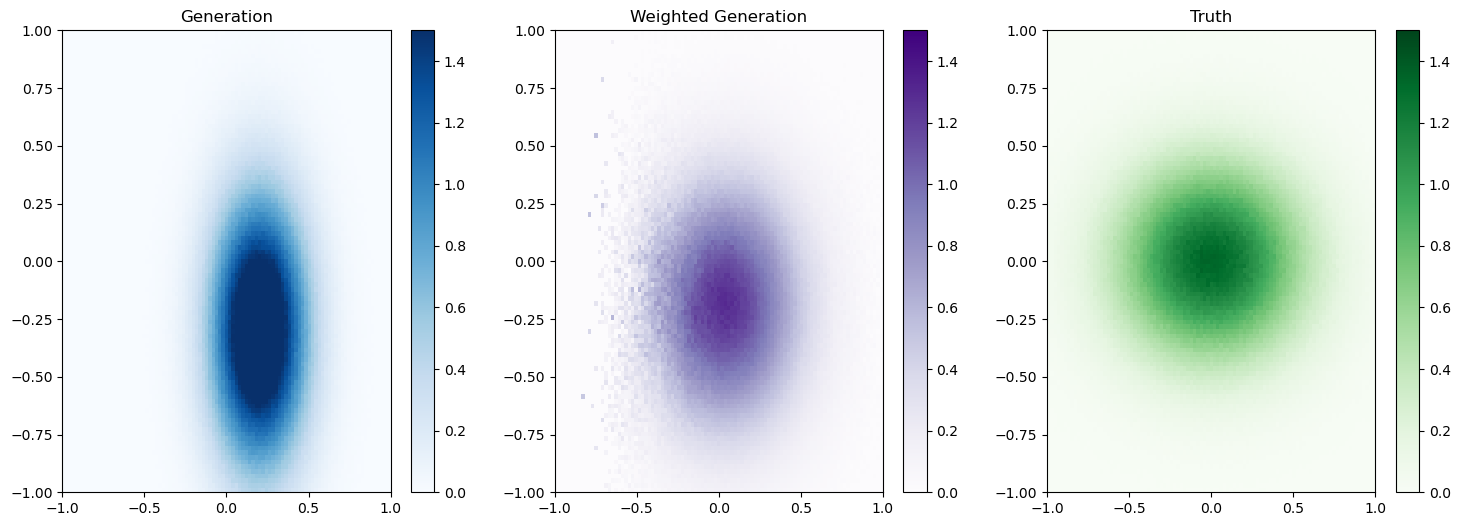

<Figure size 640x480 with 0 Axes>

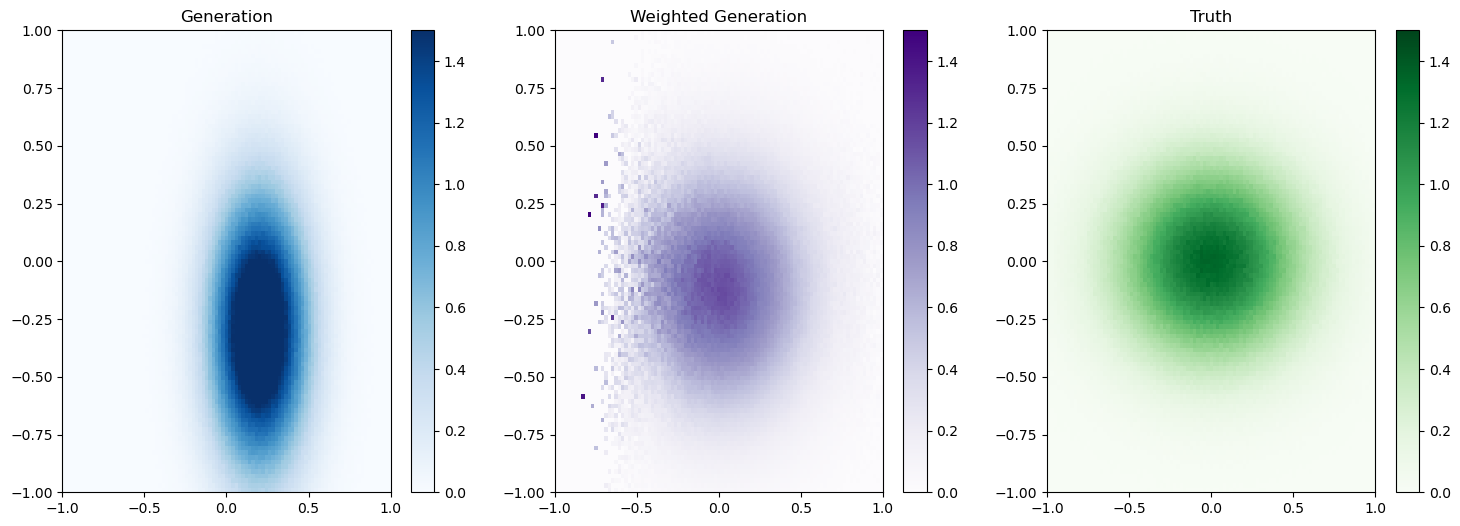

<Figure size 640x480 with 0 Axes>

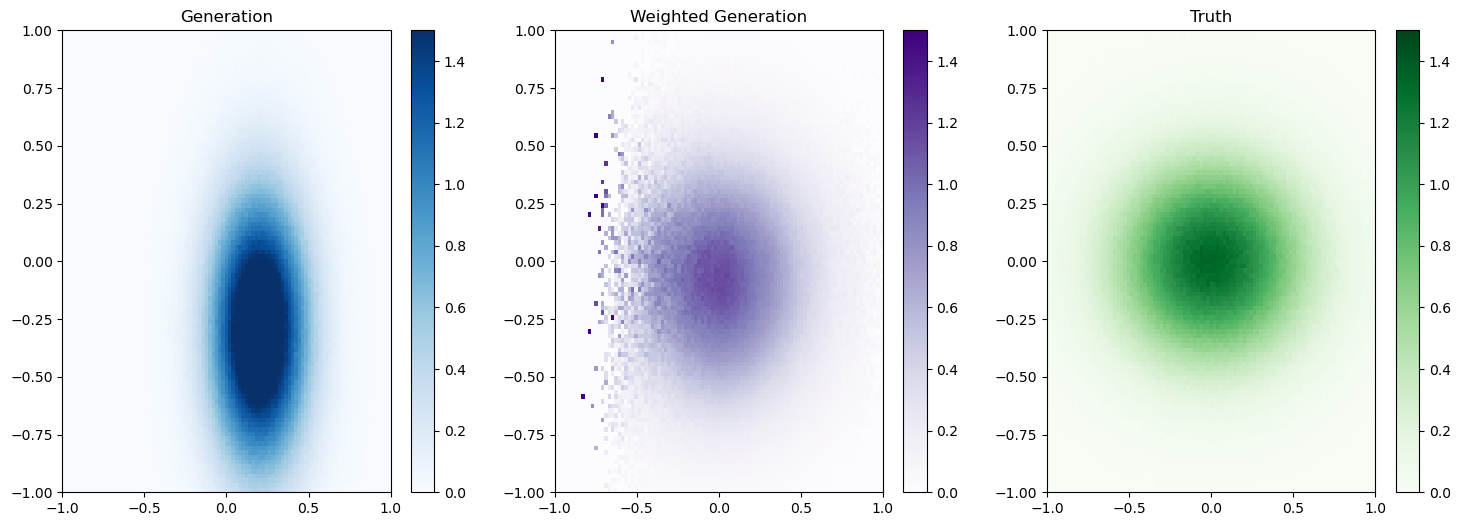

<Figure size 640x480 with 0 Axes>

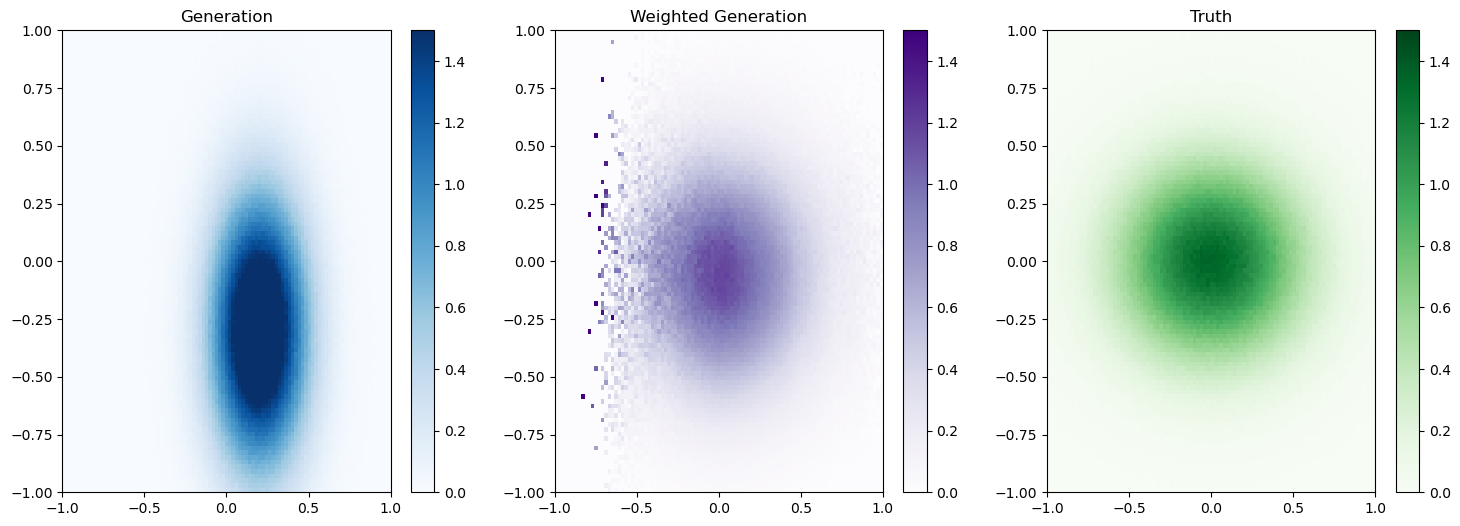

<Figure size 640x480 with 0 Axes>

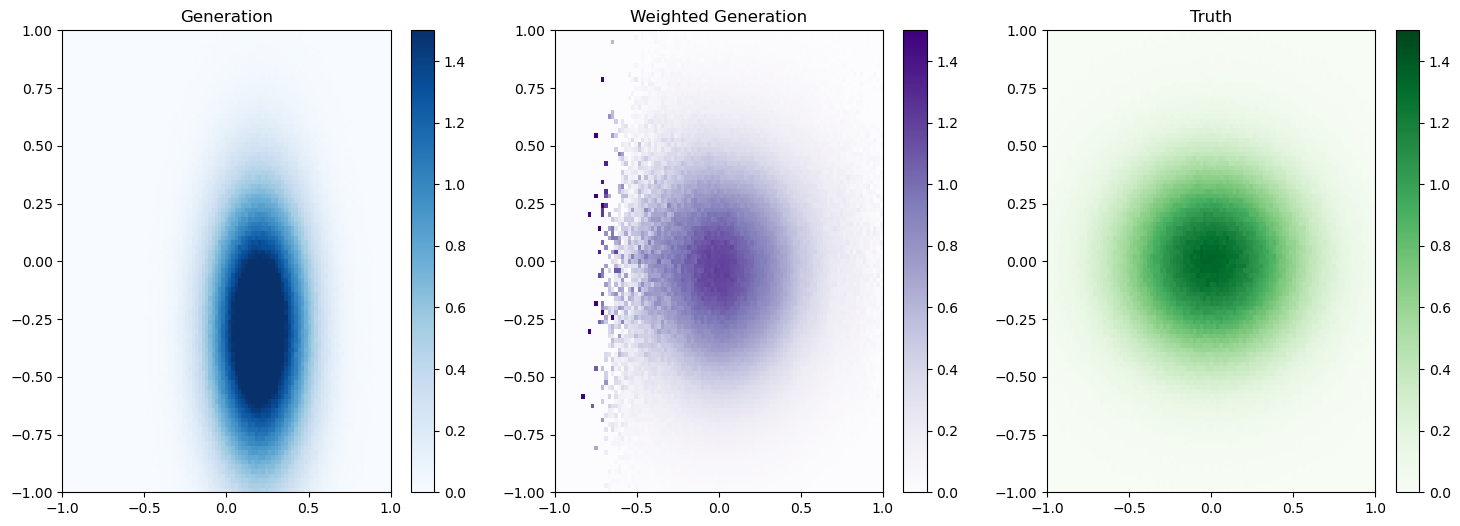

<Figure size 640x480 with 0 Axes>

In [23]:
# Make a 2D histogram of the data
for i in range(myweights.shape[0]):
    bins = [np.linspace(-1,1,100), np.linspace(-1,1,100)]
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.title('Generation')
    plt.hist2d(theta0_G[:,0], theta0_G[:,1], bins=bins, range=[[-1,1],[-1,1]], cmap='Blues', label='Generation', density=True, vmin=0, vmax=1.5)
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.title('Weighted Generation')
    plt.hist2d(theta0_G[:,0], theta0_G[:,1], weights=myweights[i,1,:], bins=bins, range=[[-1,1],[-1,1]], cmap='Purples', label='OF Generation', density=True, vmin=0, vmax=1.5)
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.title('Truth')
    plt.hist2d(theta_unknown_G[:,0], theta_unknown_G[:,1], bins=bins, range=[[-1,1],[-1,1]], cmap='Greens', label='Truth', density=True, vmin=0, vmax=1.5)
    plt.colorbar()
    plt.show()
    plt.clf()

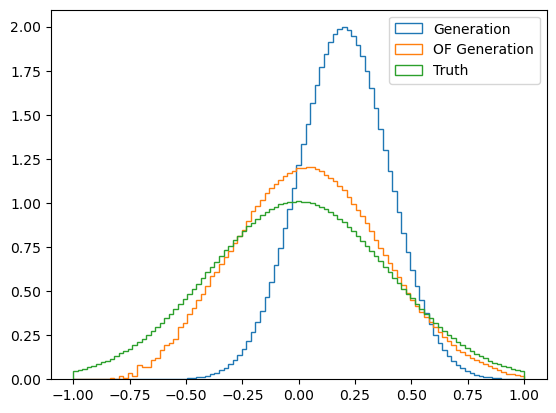

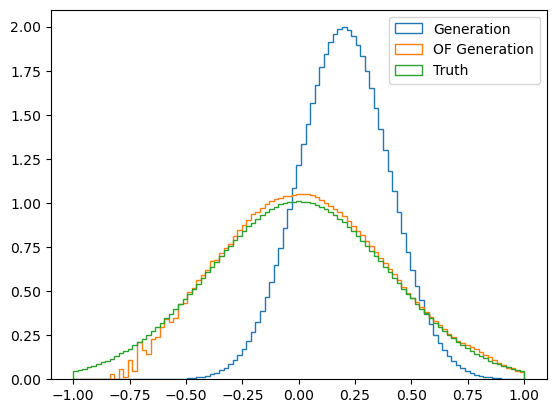

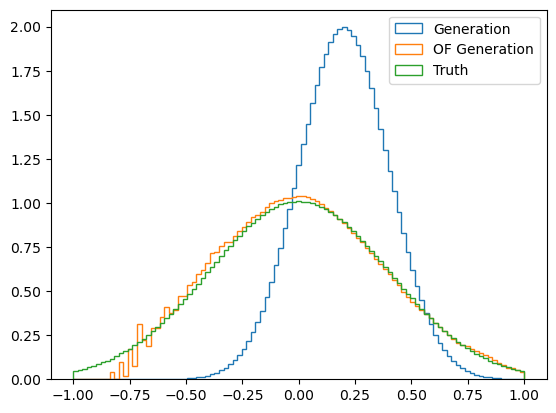

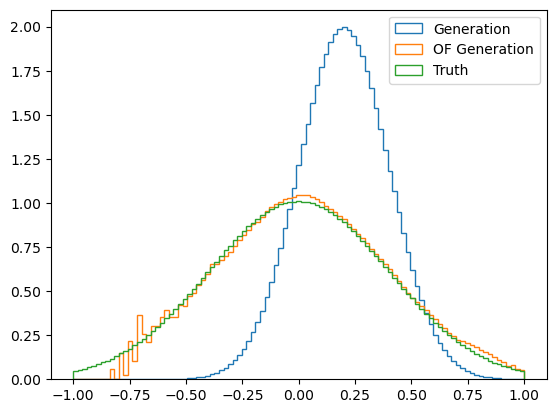

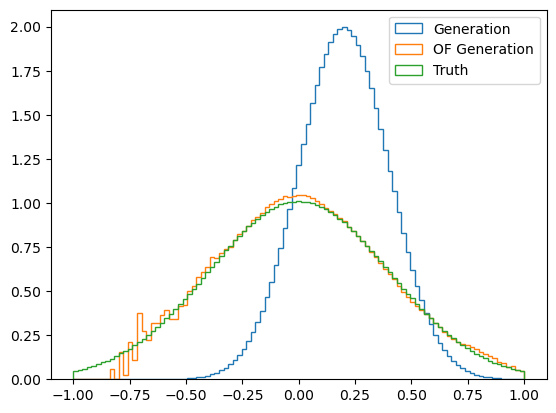

In [24]:
# Make plot for the first dimension
for i in range(myweights.shape[0]):
    bins = np.linspace(-1,1,100)
    plt.hist(theta0_G[:,0].numpy(), bins=bins, range=[-1,1], histtype='step', label='Generation', density=True)
    plt.hist(theta0_G[:,0].numpy(), weights=myweights[i,1,:], bins=bins, range=[-1,1], histtype='step', label='OF Generation', density=True)
    plt.hist(theta_unknown_G[:,0].numpy(), bins=bins, range=[-1,1], histtype='step', label='Truth', density=True)
    plt.legend()
    plt.show()

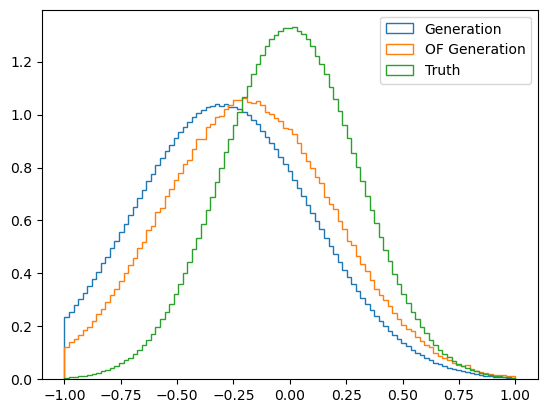

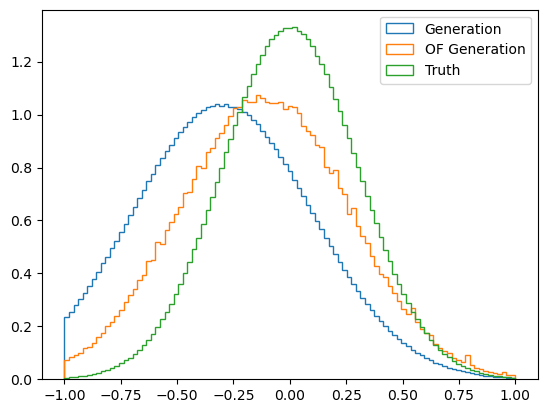

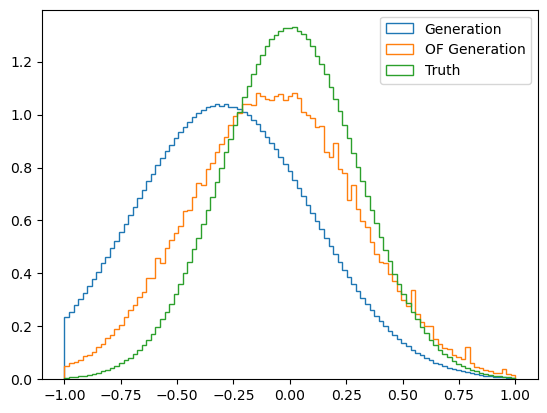

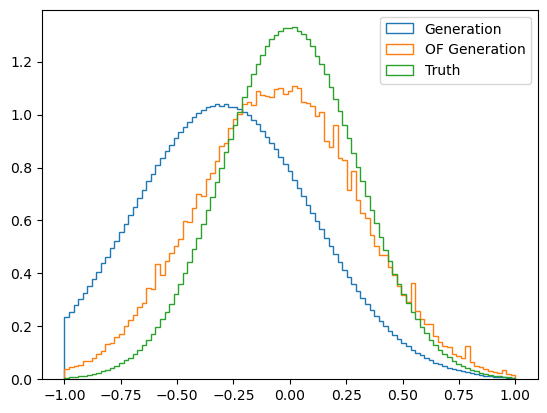

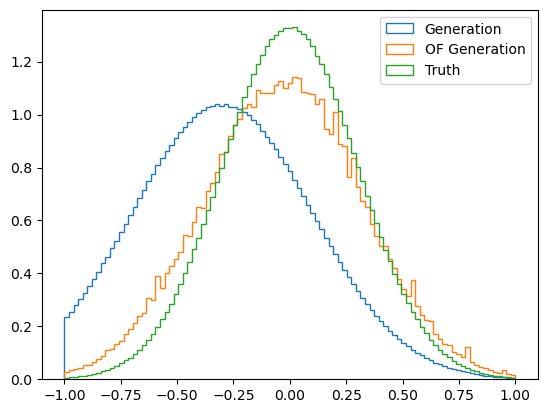

In [25]:
# Make plot for the second dimension
for i in range(myweights.shape[0]):
    bins = np.linspace(-1,1,100)
    plt.hist(theta0_G[:,1].numpy(), bins=bins, range=[-1,1], histtype='step', label='Generation', density=True)
    plt.hist(theta0_G[:,1].numpy(), weights=myweights[i,1,:], bins=bins, range=[-1,1], histtype='step', label='OF Generation', density=True)
    plt.hist(theta_unknown_G[:,1].numpy(), bins=bins, range=[-1,1], histtype='step', label='Truth', density=True)
    plt.legend()
    plt.show()

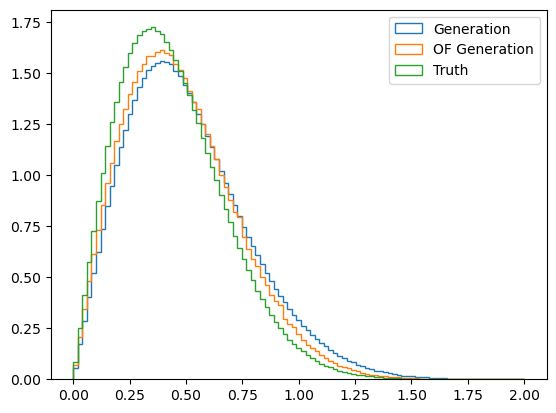

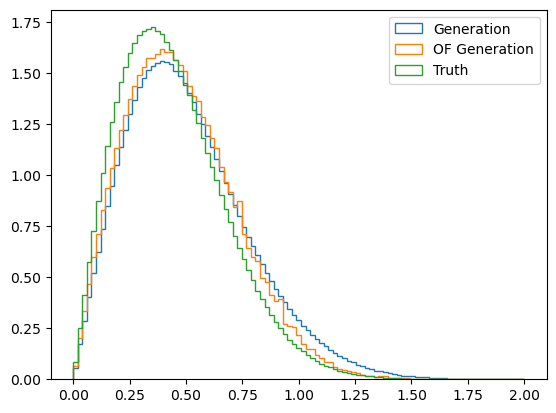

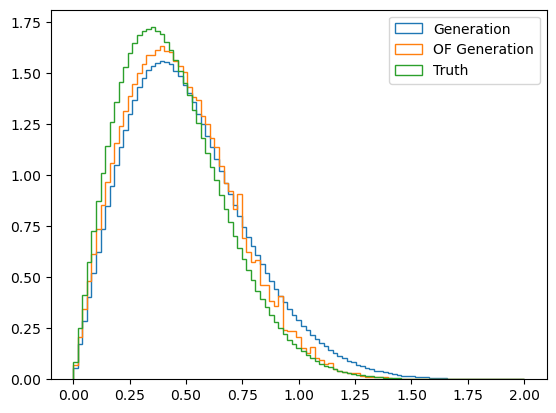

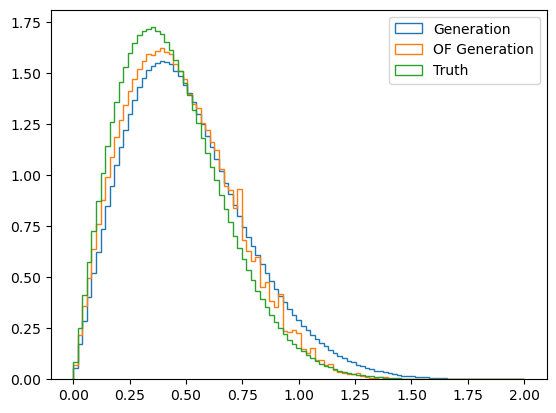

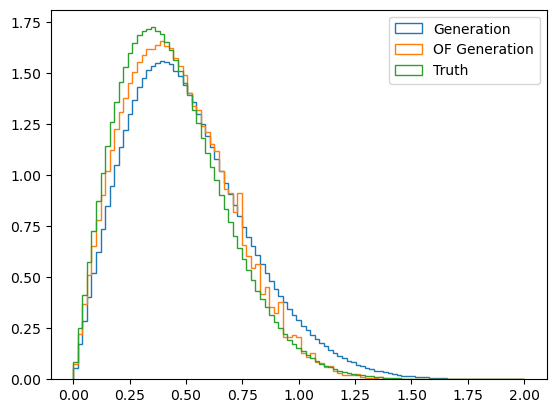

In [26]:
# Make plot for a derived dimension
derived_dim = np.sqrt(theta0_G[:,0]**2 + theta0_G[:,1]**2)
derived_dim_unknown = np.sqrt(theta_unknown_G[:,0]**2 + theta_unknown_G[:,1]**2)

for i in range(myweights.shape[0]):
    bins = np.linspace(0,2,100)
    plt.hist(derived_dim, bins=bins, histtype='step', label='Generation', density=True)
    plt.hist(derived_dim, weights=myweights[i,1,:], bins=bins, histtype='step', label='OF Generation', density=True)
    plt.hist(derived_dim_unknown, bins=bins, histtype='step', label='Truth', density=True)
    plt.legend()
    plt.show()